In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


The dataset is hosted on [Kaggle Datasets](https://kaggle.com/datasets) and therefore needs to be accessed using the command-line interface.

In [0]:
api_token = {"username":"USERNAME","key":"KEY"}
import json
import zipfile
import os
with open('/content/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [0]:
# This permissions change avoids a warning on Kaggle tool startup.
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d username/diabetic-retinopathy-resized

 99% 1.20G/1.21G [00:15<00:00, 54.6MB/s]
100% 1.21G/1.21G [00:15<00:00, 81.5MB/s]


In [5]:
!unzip diabetic-retinopathy-resized

Archive:  diabetic-retinopathy-resized.zip
  inflating: resized_train.zip       
  inflating: trainLabels.csv         


In [6]:
!unzip resized_train -d resized_train

Archive:  resized_train.zip
   creating: resized_train/resized_train/
  inflating: resized_train/resized_train/10003_left.jpeg  
  inflating: resized_train/resized_train/10003_right.jpeg  
  inflating: resized_train/resized_train/10007_left.jpeg  
  inflating: resized_train/resized_train/10007_right.jpeg  
  inflating: resized_train/resized_train/10009_left.jpeg  
  inflating: resized_train/resized_train/10009_right.jpeg  
  inflating: resized_train/resized_train/1000_left.jpeg  
  inflating: resized_train/resized_train/1000_right.jpeg  
  inflating: resized_train/resized_train/10010_left.jpeg  
  inflating: resized_train/resized_train/10010_right.jpeg  
  inflating: resized_train/resized_train/10013_left.jpeg  
  inflating: resized_train/resized_train/10013_right.jpeg  
  inflating: resized_train/resized_train/10014_left.jpeg  
  inflating: resized_train/resized_train/10014_right.jpeg  
  inflating: resized_train/resized_train/10015_left.jpeg  
  inflating: resized_train/resized_train

In [7]:
import os
files = os.listdir('resized_train/resized_train')
print(len(files)) 

35126


In [8]:
import fastai; fastai.__version__

'1.0.52'

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks import *
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


In [12]:
base_image_dir = '.'
df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'resized_train/resized_train','{}.jpeg'.format(x)))
df = df.drop(columns=['image'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df['level'] = (df['level'] > 1).astype(int)
df.head(10)

,level,path
0,1,./resized_train/resized_train/37923_right.jpeg
1,0,./resized_train/resized_train/20995_right.jpeg
2,0,./resized_train/resized_train/32008_left.jpeg
3,0,./resized_train/resized_train/34403_right.jpeg
4,0,./resized_train/resized_train/6759_left.jpeg
5,0,./resized_train/resized_train/36199_left.jpeg
6,0,./resized_train/resized_train/14648_left.jpeg
7,1,./resized_train/resized_train/14915_left.jpeg
8,0,./resized_train/resized_train/35089_left.jpeg
9,1,./resized_train/resized_train/9952_right.jpeg


In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

7026

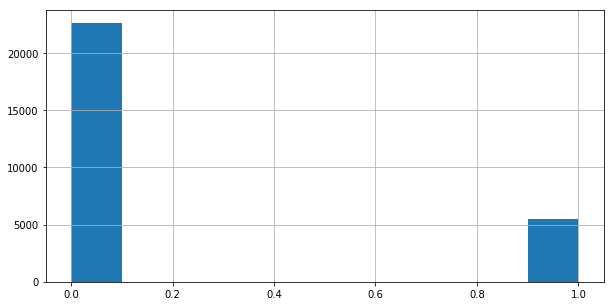

In [14]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [15]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

35126

In [0]:
bs = 16 #smaller batch size is better for training, but may take longer
sz=512

In [0]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=None,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH) #Data augmentation
        .databunch(bs=bs,num_workers=4) #DataBunch
        .normalize(imagenet_stats) #Normalize     
       )

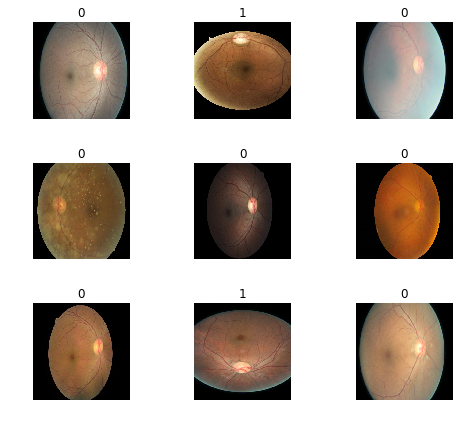

In [18]:
data.show_batch(rows=3, figsize=(7,6))

In [19]:
print(data.classes)
len(data.classes),data.c

[0, 1]


(2, 2)

In [20]:
from torchvision.models import *
learn = create_cnn(data, resnet50, wd = 1e-5, metrics = [accuracy,AUROC()],callback_fns=[partial(CSVLogger,append=True)], 
                   path = Path('gdrive/My Drive/DRmodels5')).to_fp16()

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:04, 24480702.33it/s]


In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06


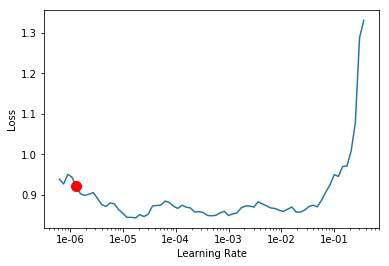

In [0]:
learn.recorder.plot(suggestion=True)

In [22]:
learn.fit_one_cycle(1,max_lr = 1e-2)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.349270,0.321406,0.875053,0.869455,26:26


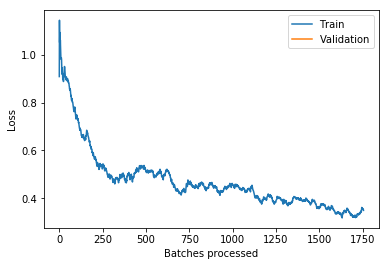

In [23]:
learn.recorder.plot_losses()

In [0]:
learn.unfreeze()

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


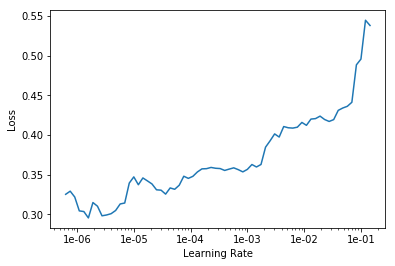

In [26]:
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3),callbacks=[SaveModelCallback(learn, every='epoch')])

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.340733,0.306518,0.885300,0.877132,27:05
1,0.323907,0.360569,0.879038,0.864325,26:40
2,0.325459,0.300723,0.886011,0.884917,25:20
3,0.330807,0.299110,0.882596,0.891482,24:04
4,0.304616,0.287838,0.890138,0.895941,23:42
5,0.287163,0.279499,0.895830,0.900935,24:16
6,0.259362,0.266917,0.899103,0.908747,26:54


Buffered data was truncated after reaching the output size limit.

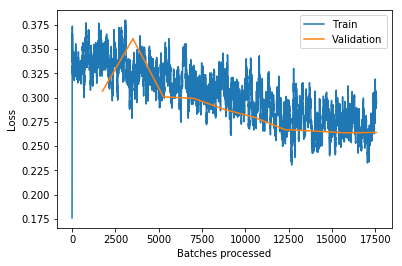

In [28]:
learn.recorder.plot_losses()

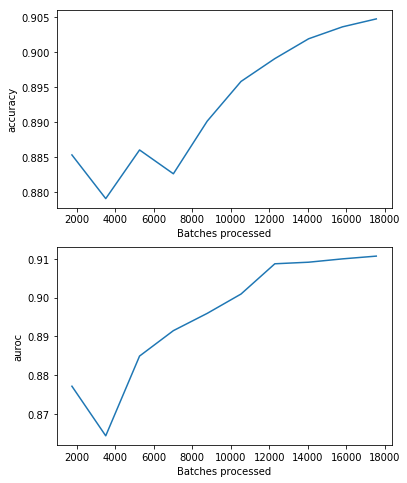

In [29]:
learn.recorder.plot_metrics()

In [0]:
learn.save('stage-2-512')

In [0]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

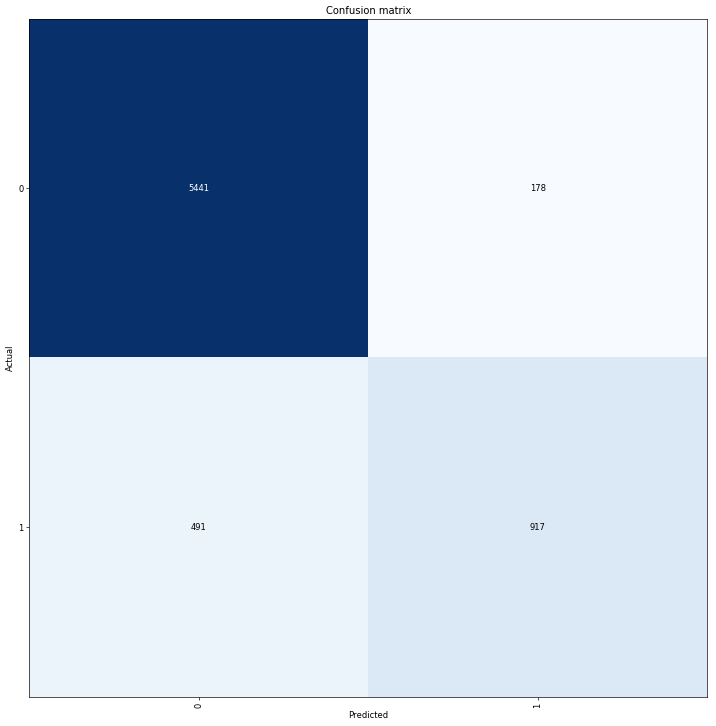

In [32]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [33]:
from sklearn.metrics import roc_auc_score
def auc_score(y_score,y_true):
    try:
      auc = torch.tensor(roc_auc_score(y_true,y_score[:,1]))
    except:
      auc = torch.tensor(np.nan)
    return auc

probs,val_labels = learn.get_preds(ds_type=DatasetType.Valid) 
print('Accuracy',accuracy(probs,val_labels)),
print('Error Rate', error_rate(probs, val_labels))
print('AUC', auc_score(probs,val_labels))

Accuracy tensor(0.9048)
Error Rate tensor(0.0952)
AUC tensor(0.9107)


In [34]:
from sklearn.metrics import roc_curve
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 
  

print(probs[:,1]) 
from sklearn.metrics import confusion_matrix

threshold = Find_Optimal_Cutoff(val_labels,probs[:,1])
print(threshold)

print(confusion_matrix(val_labels,probs[:,1]>threshold[0]))


tensor([0.0141, 0.0441, 0.1795,  ..., 0.9849, 0.0505, 0.0838])
[0.17681370675563812]
[[4663  956]
 [ 241 1167]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [0]:
learn.export()